<a href="https://colab.research.google.com/github/oitik/Robovox_Challenge/blob/master/Robovox_final_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing & Importing Library

In [ ]:

# If you're using Google Colab and not running locally, run this cell.

# Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode

## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

# Install TorchAudio
!pip install torchaudio>=0.10.0 -f https://download.pytorch.org/whl/torch_stable.html


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
sox is already the newest version (14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
DEPRECATION: git+https://github.com/NVIDIA/NeMo.git@main#egg=nemo_toolkit[asr] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-wwv0ypwc/nemo-toolkit_9488ab97d2df47fab8f367824b31c765
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/NeMo.git /tmp/pip-install-wwv0ypwc/nemo-toolkit_9488ab97d2df47fab8f367824b31c765
  Re

In [ ]:
import glob
import pandas as pd
import tqdm
from tqdm import tqdm
from tqdm.notebook import tqdm
from scipy.spatial.distance import cosine
import numpy as np
import zipfile
from io import BytesIO
from pydub import AudioSegment
import json

#Mounting Google Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
data_dir = os.path.join('/content/drive/MyDrive/dataset/single-channel/denoised')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preprocessing

In [ ]:
import torchaudio
import numpy as np
from tqdm.notebook import tqdm
def normalize_and_save(audio_path):
    # Load audio file
    waveform, sample_rate = torchaudio.load(audio_path)

    # Calculate the maximum absolute value
    max_amplitude = torch.max(torch.abs(waveform))

    # Normalize the audio signal to the range [-1, 1]
    normalized_audio = waveform / max_amplitude

    # Save the normalized audio to the same file path
    torchaudio.save(audio_path, normalized_audio, sample_rate)

In [ ]:
def paths(fpath):
    '''
    Chill..

    fpath: Folder Path
    '''
    wav_paths = []
    for dirname, _, filenames in os.walk(fpath):
        for filename in filenames:
            if filename.endswith('.wav'):
                wav_paths.append(os.path.join(dirname, filename))
    return wav_paths


In [ ]:
enr_paths = paths('/content/drive/MyDrive/dataset/single-channel/denoised')
enr_paths[:3]

['/content/drive/MyDrive/dataset/single-channel/denoised/spk_32-32_39_1_0_d1_ch5.wav',
 '/content/drive/MyDrive/dataset/single-channel/denoised/spk_31-31_10_0_0_d5_ch5.wav',
 '/content/drive/MyDrive/dataset/single-channel/denoised/spk_39-39_21_0_0_d5_ch5.wav']

In [ ]:
mx_amp = []

for row in tqdm(enr_paths, total=len(enr_paths)):
    waveform, _ = torchaudio.load(row)
    mx = np.min(waveform.numpy())
    mx_amp.append(mx)

  0%|          | 0/225 [00:00<?, ?it/s]

In [ ]:
mx_amp = sorted(mx_amp, reverse=0)
mx_amp[:10]

[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]

In [ ]:
import multiprocessing

# Get the number of CPU cores in Colab
num_cores = multiprocessing.cpu_count()

print("Number of CPU cores in Colab:", num_cores)

# with ThreadPoolExecutor(max_workers=max_workers)

Number of CPU cores in Colab: 2


In [ ]:
import torch
from concurrent.futures import ThreadPoolExecutor

# Using ThreadPoolExecutor for parallel processing with tqdm
with ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(normalize_and_save, enr_paths), total=len(enr_paths), desc='Processing'))

Processing:   0%|          | 0/225 [00:00<?, ?it/s]

In [ ]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

def sample_audio(filename):
    # Load the audio file
    data, sample_rate = torchaudio.load(filename)

    # Plot the waveform
    plt.figure(figsize=(7, 3))
    plt.plot(data[0].numpy())
    plt.title('Waveform')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()

    # Play the audio
    return ipd.Audio(data, rate=sample_rate)

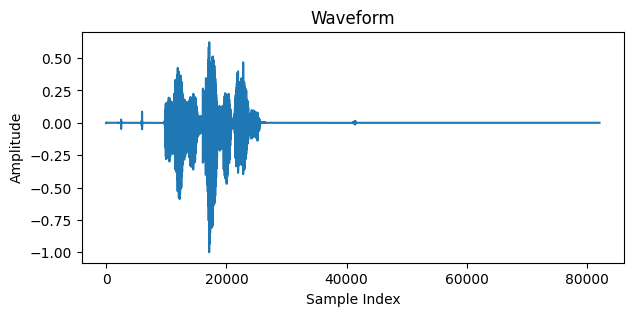

In [ ]:
sample_audio('/content/drive/MyDrive/dataset/single-channel/denoised/spk_36-36_11_0_0_d6_ch5.wav')

In [ ]:
dn_test_paths = paths('/content/drive/MyDrive/dataset/single-channel/denoised_test')
dn_test_paths[:8]

['/content/drive/MyDrive/dataset/single-channel/denoised_test/21b697b4f5.wav',
 '/content/drive/MyDrive/dataset/single-channel/denoised_test/c43b415c74.wav',
 '/content/drive/MyDrive/dataset/single-channel/denoised_test/c3f6592a37.wav',
 '/content/drive/MyDrive/dataset/single-channel/denoised_test/21fc90b2ac.wav',
 '/content/drive/MyDrive/dataset/single-channel/denoised_test/26b0e8e0e8.wav',
 '/content/drive/MyDrive/dataset/single-channel/denoised_test/25b1bdd709.wav',
 '/content/drive/MyDrive/dataset/single-channel/denoised_test/2654678988.wav',
 '/content/drive/MyDrive/dataset/single-channel/denoised_test/23f6919d8f.wav']

In [ ]:
from concurrent.futures import ThreadPoolExecutor

# Using ThreadPoolExecutor for parallel processing with tqdm
with ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(normalize_and_save, dn_test_paths), total=len(dn_test_paths), desc='Processing'))

Processing:   0%|          | 0/10332 [00:00<?, ?it/s]

In [ ]:
print('hello')

hello


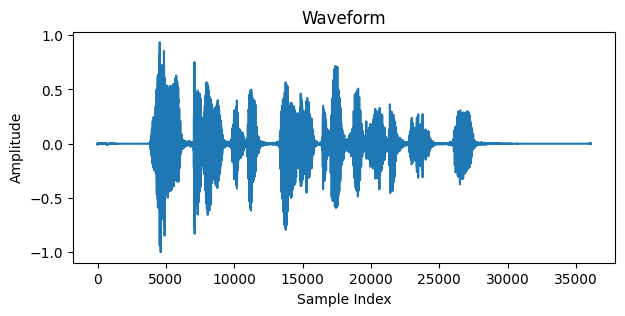

In [ ]:
tp = '/content/drive/MyDrive/dataset/single-channel/denoised_test/008a2d1b07.wav'
sample_audio(tp)

4299


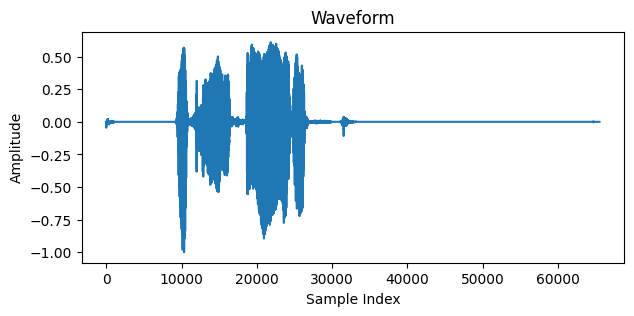

In [ ]:
ri = np.random.randint(0, 10000)
print(ri)

sample_audio(dn_test_paths[ri])

#Creating Json file
The file will created to the output path then we manually need to split it to train and test json file . Need to remember should not take all 3 value from a user to test json. then need to upload json file to enrollment directory

In [ ]:
import os
from pydub import AudioSegment
import json

# Define the directory containing your audio files
audio_directory = '/content/drive/MyDrive/dataset/single-channel/enrollment'

# Define the output JSON file path
output_json_path = '/content/drive/MyDrive/dataset/single-channel/enrollment/audio_info.json'


# Iterate over each .wav file in the directory and create JSON entries
with open(output_json_path, 'w', encoding='utf-8') as json_file:
    for filename in os.listdir(audio_directory):
        if filename.endswith('.wav'):
            audio_filepath = os.path.join(audio_directory, filename)

            # Extract audio duration using pydub
            audio = AudioSegment.from_file(audio_filepath)
            duration_seconds = len(audio) / 1000.0

            # Extract label from the filename
            label = filename.split('-')[0]

            # Create a dictionary with audio information
            audio_info = {
                "audio_filepath": audio_filepath,
                "offset": 0,  # You can adjust the offset if needed
                "duration": duration_seconds,
                "label": label
            }

            # Serialize the dictionary and write to the file
            json_file.write(json.dumps(audio_info))
            json_file.write('\n')  # Add a new line after each entry

print(f"JSON file created at: {output_json_path}")


JSON file created at: /content/drive/MyDrive/dataset/single-channel/enrollment/audio_info.json


In [ ]:
train_manifest = os.path.join(data_dir,'/content/drive/MyDrive/dataset/single-channel/enrollment/train.json')
validation_manifest = os.path.join(data_dir,'/content/drive/MyDrive/dataset/single-channel/enrollment/test.json')
test_manifest = os.path.join(data_dir,'/content/drive/MyDrive/dataset/single-channel/enrollment/test.json')

#Importing Nemo Library

In [ ]:
import nemo
# NeMo's ASR collection - This collection contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr
from omegaconf import OmegaConf

[NeMo W 2024-01-27 10:57:38 transformer_bpe_models:62] Could not import NeMo NLP collection which is required for speech translation model.


In [ ]:
import os
NEMO_ROOT='/content/'

#import config file.
You need to tune model parameter here

In [ ]:
# This line will print the entire config of sample TitaNet model
!mkdir conf
!wget -P conf https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/speaker_tasks/recognition/conf/titanet-small.yaml
MODEL_CONFIG = os.path.join(NEMO_ROOT,'conf/titanet-small.yaml')
config = OmegaConf.load(MODEL_CONFIG)

--2024-01-27 10:57:41--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/recognition/conf/titanet-small.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4526 (4.4K) [text/plain]
Saving to: ‘conf/titanet-small.yaml’

titanet-small.yaml  100%[===================>]   4.42K  --.-KB/s    in 0s      

2024-01-27 10:57:41 (53.3 MB/s) - ‘conf/titanet-small.yaml’ saved [4526/4526]



In [ ]:
MODEL_CONFIG = os.path.join(NEMO_ROOT,'conf/titanet-small.yaml')
config = OmegaConf.load(MODEL_CONFIG)
print(OmegaConf.to_yaml(config))

name: TitaNet-S
sample_rate: 16000
model:
  train_ds:
    manifest_filepath: ???
    sample_rate: 16000
    labels: null
    batch_size: 4
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: null
        prob: 0.5
        min_snr_db: 5
        max_snr_db: 15
      impulse:
        manifest_path: null
        prob: 0.5
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
  validation_ds:
    manifest_filepath: ???
    sample_rate: 16000
    labels: null
    batch_size: 4
    shuffle: false
  model_defaults:
    filters: 256
    repeat: 3
    dropout: 0.1
    separable: true
    se: true
    se_context_size: -1
    kernel_size_factor: 1.0
  preprocessor:
    _target_: nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor
    normalize: per_feature
    window_size: 0.025
    sample_rate: 

In [ ]:
# config.model.train_ds.batch_size=2
# config.model.validation_ds.batch_size=2

In [ ]:
config.model.train_ds.manifest_filepath = train_manifest
config.model.validation_ds.manifest_filepath = validation_manifest
config.model.decoder.num_classes = 78

#importing Torch
setting up enviornment

In [ ]:
import torch
import pytorch_lightning as pl

In [ ]:
# Let us modify some trainer configs for this demo
# Checks if we have GPU available and uses it
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print(accelerator)
config.trainer.devices = 1
config.trainer.accelerator = accelerator

# Reduces maximum number of epochs to 5 for quick demonstration
config.trainer.max_epochs = 10

# Remove distributed training flags
config.trainer.strategy = 'auto'

# Remove augmentations
config.model.train_ds.augmentor=None

gpu


In [ ]:
print(OmegaConf.to_yaml(config.model.train_ds))
print(OmegaConf.to_yaml(config.model.validation_ds))

manifest_filepath: /content/drive/MyDrive/dataset/single-channel/enrollment/train.json
sample_rate: 16000
labels: null
batch_size: 4
shuffle: true
is_tarred: false
tarred_audio_filepaths: null
tarred_shard_strategy: scatter
augmentor: null

manifest_filepath: /content/drive/MyDrive/dataset/single-channel/enrollment/test.json
sample_rate: 16000
labels: null
batch_size: 4
shuffle: false



In [ ]:
trainer = pl.Trainer(**config.trainer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [ ]:
from nemo.utils.exp_manager import exp_manager
log_dir = exp_manager(trainer, config.get("exp_manager", None))
# The log_dir provides a path to the current logging directory for easy access
print(log_dir)

[NeMo I 2024-01-27 10:58:45 exp_manager:396] Experiments will be logged at /content/nemo_experiments/TitaNet-S/2024-01-27_10-58-45
[NeMo I 2024-01-27 10:58:45 exp_manager:842] TensorboardLogger has been set up
/content/nemo_experiments/TitaNet-S/2024-01-27_10-58-45


In [ ]:
model = nemo_asr.models.EncDecSpeakerLabelModel(cfg=config.model, trainer=trainer)

[NeMo I 2024-01-27 10:58:47 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-27 10:58:47 collections:446] Dataset loaded with 218 items, total duration of  0.40 hours.
[NeMo I 2024-01-27 10:58:47 collections:448] # 218 files loaded accounting to # 75 labels


[NeMo W 2024-01-27 10:58:47 label_models:189] Total number of 75 found in all the manifest files.


[NeMo I 2024-01-27 10:58:47 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-27 10:58:47 collections:446] Dataset loaded with 218 items, total duration of  0.40 hours.
[NeMo I 2024-01-27 10:58:47 collections:448] # 218 files loaded accounting to # 75 labels
[NeMo I 2024-01-27 10:58:47 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-01-27 10:58:47 collections:446] Dataset loaded with 7 items, total duration of  0.01 hours.
[NeMo I 2024-01-27 10:58:47 collections:448] # 7 files loaded accounting to # 7 labels
[NeMo I 2024-01-27 10:58:47 features:289] PADDING: 16


In [ ]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2024-01-27 10:58:52 modelPT:719] Optimizer config = SGD (
    Parameter Group 0
        dampening: 0
        differentiable: False
        foreach: None
        lr: 0.006
        maximize: False
        momentum: 0.9
        nesterov: False
        weight_decay: 0.001
    )
[NeMo I 2024-01-27 10:58:52 lr_scheduler:915] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x77ff07ba70a0>" 
    will be used during training (effective maximum steps = 550) - 
    Parameters : 
    (warmup_ratio: 0.1
    min_lr: 0.0
    max_steps: 550
    )


INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | loss              | AngularSoftmaxLoss                | 0     
1 | eval_loss         | AngularSoftmaxLoss                | 0     
2 | _accuracy         | TopKClassificationAccuracy        | 0     
3 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
4 | encoder           | ConvASREncoder                    | 4.1 M 
5 | decoder           | SpeakerDecoder                    | 2.8 M 
6 | _macro_accuracy   | MulticlassAccuracy                | 0     
7 | spec_augmentation | SpectrogramAugmentation           | 0     
------------------------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.361    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

[NeMo I 2024-01-27 10:58:55 preemption:56] Preemption requires torch distributed to be initialized, disabling preemption


[NeMo W 2024-01-27 10:58:55 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('global_step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
      warning_cache.warn(
    


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 55: 'val_loss' reached 11.54817 (best 11.54817), saving model to '/content/nemo_experiments/TitaNet-S/2024-01-27_10-58-45/checkpoints/TitaNet-S--val_loss=11.5482-epoch=0.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 110: 'val_loss' reached 11.15149 (best 11.15149), saving model to '/content/nemo_experiments/TitaNet-S/2024-01-27_10-58-45/checkpoints/TitaNet-S--val_loss=11.1515-epoch=1.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 165: 'val_loss' reached 11.25269 (best 11.15149), saving model to '/content/nemo_experiments/TitaNet-S/2024-01-27_10-58-45/checkpoints/TitaNet-S--val_loss=11.2527-epoch=2.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 220: 'val_loss' reached 11.19278 (best 11.15149), saving model to '/content/nemo_experiments/TitaNet-S/2024-01-27_10-58-45/checkpoints/TitaNet-S--val_loss=11.1928-epoch=3.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 275: 'val_loss' reached 10.55398 (best 10.55398), saving model to '/content/nemo_experiments/TitaNet-S/2024-01-27_10-58-45/checkpoints/TitaNet-S--val_loss=10.5540-epoch=4.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 330: 'val_loss' reached 10.65989 (best 10.55398), saving model to '/content/nemo_experiments/TitaNet-S/2024-01-27_10-58-45/checkpoints/TitaNet-S--val_loss=10.6599-epoch=5.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 385: 'val_loss' reached 10.52785 (best 10.52785), saving model to '/content/nemo_experiments/TitaNet-S/2024-01-27_10-58-45/checkpoints/TitaNet-S--val_loss=10.5279-epoch=6.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 440: 'val_loss' reached 10.32314 (best 10.32314), saving model to '/content/nemo_experiments/TitaNet-S/2024-01-27_10-58-45/checkpoints/TitaNet-S--val_loss=10.3231-epoch=7.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 495: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 550: 'val_loss' reached 10.39421 (best 10.32314), saving model to '/content/nemo_experiments/TitaNet-S/2024-01-27_10-58-45/checkpoints/TitaNet-S--val_loss=10.3942-epoch=9.ckpt' as top 3
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# Restoring the model

In [ ]:
import glob
checkpoint_dir = os.path.join(log_dir, 'checkpoints')
checkpoint_paths = list(glob.glob(os.path.join(checkpoint_dir, "*.ckpt")))
checkpoint_paths
final_checkpoint = list(filter(lambda x: "-last.ckpt" in x, checkpoint_paths))[0]
prediction_model = nemo_asr.models.EncDecSpeakerLabelModel.load_from_checkpoint(final_checkpoint)


[NeMo W 2024-01-27 11:00:25 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /content/drive/MyDrive/dataset/single-channel/enrollment/train.json
    sample_rate: 16000
    labels:
    - spk_10
    - spk_11
    - spk_12
    - spk_13
    - spk_14
    - spk_15
    - spk_16
    - spk_17
    - spk_18
    - spk_19
    - spk_2
    - spk_20
    - spk_21
    - spk_22
    - spk_23
    - spk_24
    - spk_25
    - spk_26
    - spk_27
    - spk_28
    - spk_29
    - spk_3
    - spk_30
    - spk_31
    - spk_32
    - spk_33
    - spk_34
    - spk_35
    - spk_36
    - spk_37
    - spk_38
    - spk_39
    - spk_4
    - spk_40
    - spk_41
    - spk_42
    - spk_43
    - spk_44
    - spk_45
    - spk_46
    - spk_47
    - spk_48
    - spk_49
    - spk_5
    - spk_50
    - spk_51
    - spk_52
    - spk_53
    - spk_54
    - spk_5

[NeMo I 2024-01-27 11:00:25 features:289] PADDING: 16


#give the path of desired file
here x1_dir=enrollment <br>
x2_dir=test

In [ ]:
test_file='/content/drive/MyDrive/dataset/single-channel/signle-channel-trials.trl'
x1_dir='/content/drive/MyDrive/dataset/single-channel/denoised'
x2_dir='/content/drive/MyDrive/dataset/single-channel/denoised_test'

In [ ]:
def name_extractor(x1,dir):
   output_list=[]
   c=0
   for filename in os.listdir(dir):
      if filename.endswith('.wav'):
          audio_filepath = os.path.join(dir, filename)
          label = filename.split('-')[0]
          c+=1
          if label==x1:
            output_list.append(audio_filepath)

   return output_list


In [ ]:
import pandas as pd

#Creating submit file as a dataframe and also read tsv trial file

In [ ]:
columns = ['enroll ID', 'test ID', 'score']
submit_df = pd.DataFrame(columns=columns)
# Read the TSV file into a pandas DataFrame
trial_df = pd.read_csv(test_file, sep='\t',header=None,encoding='utf-8')
# Now 'df' is a pandas DataFrame containing your data
print(trial_df)

             0           1
0       spk_71  b80bb95d16
1       spk_71  e64da37b33
2       spk_71  c22d8f9d8a
3       spk_71  20e087d5bf
4       spk_71  c5396d4af7
...        ...         ...
102553   spk_9  d1dace1ec5
102554   spk_9  5db262e132
102555   spk_9  ff2a6ce91c
102556   spk_9  32af828478
102557   spk_9  f25a894502

[102558 rows x 2 columns]


In [ ]:
submit_df

,enroll ID,test ID,score


In [ ]:
c=0
for filename in os.listdir('/content/drive/MyDrive/dataset/single-channel/denoised_test'):
  c+=1

print(c)

10332


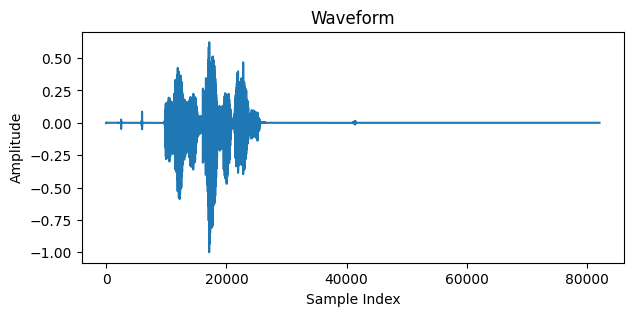

In [ ]:
sample_audio('/content/drive/MyDrive/dataset/single-channel/denoised/spk_36-36_11_0_0_d6_ch5.wav')

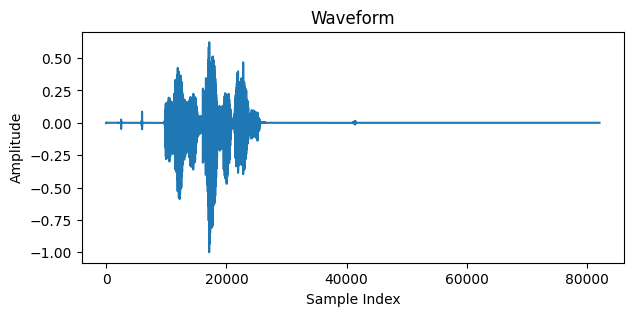

In [ ]:
# normalize_and_save('/content/drive/MyDrive/dataset/single-channel/denoised/spk_36-36_11_0_0_d6_ch5.wav')
sample_audio('/content/drive/MyDrive/dataset/single-channel/denoised/spk_36-36_11_0_0_d6_ch5.wav')

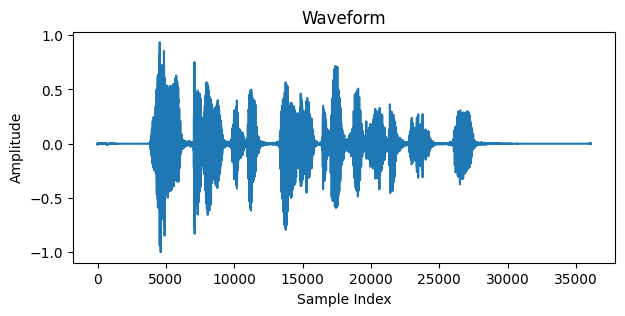

In [ ]:
tp = '/content/drive/MyDrive/dataset/single-channel/denoised_test/008a2d1b07.wav'
sample_audio(tp)

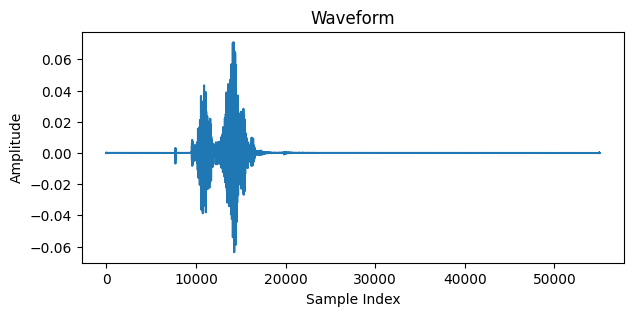

In [ ]:
sample_audio('/content/drive/MyDrive/dataset/single-channel/denoised_test/d1dace1ec5.wav')

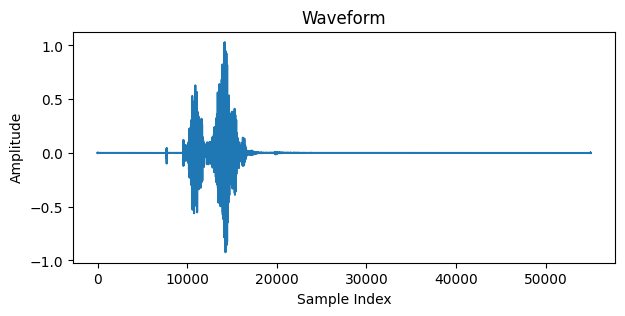

In [ ]:
# normalize_and_save('/content/drive/MyDrive/dataset/single-channel/denoised_test/d1dace1ec5.wav')
sample_audio('/content/drive/MyDrive/dataset/single-channel/denoised_test/d1dace1ec5.wav')

In [ ]:
def cosine_distance(vector1, vector2):
    '''
    vector1: shape 6144
    vector2: shape 6144
    '''
    vector1 = np.array(vector1).reshape(1, -1)
    vector2 = np.array(vector2).reshape(1, -1)

    similarity_matrix = cosine_similarity(vector1, vector2)

    distance = 1 - similarity_matrix[0, 0]

    return distance

In [ ]:
filt = trial_df[:3]
filt

,0,1
0,spk_71,b80bb95d16
1,spk_71,e64da37b33
2,spk_71,c22d8f9d8a


#Calculating so called final score


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

# Assuming cosine similarity function is imported
from scipy.spatial.distance import cosine

tqdm_iterator = tqdm(trial_df[:10].iterrows(), total=len(trial_df[:10]), desc='Processing Rows')

# Initialize an empty list to store data for faster concatenation
data_to_add_list = []

# Dictionary to store computed embeddings for enroll audios
computed_embeddings_x1 = {}
computed_embeddings_x2 = {}

# Batch size for embeddings processing
batch_size = 32

# Helper function to compute embeddings for a batch of audio paths
def compute_batch_embeddings(audio_paths, model):
    embeddings = []
    for path in audio_paths:
        embedding = model.get_embedding(path).cpu().squeeze().numpy()
        embeddings.append(embedding)
    return np.array(embeddings)

# Iterate through rows using tqdm
for index, row in tqdm_iterator:
    x1, x2 = row[0], row[1]
    x1_path = name_extractor(x1, x1_dir)
    x2_path = '/content/drive/MyDrive/dataset/single-channel/denoised_test/' + x2 + '.wav'

    # Use cached embeddings if available, otherwise compute and cache for x1
    if x1 not in computed_embeddings_x1:
        computed_embeddings_x1[x1] = compute_batch_embeddings(x1_path, prediction_model)

    emb_x1 = computed_embeddings_x1[x1]

    # Use cached embeddings if available, otherwise compute and cache for x2
    if x2 not in computed_embeddings_x2:
        computed_embeddings_x2[x2] = compute_batch_embeddings([x2_path], prediction_model)[0]

    emb_x2 = computed_embeddings_x2[x2]

    # Compute cosine similarity for each dimension separately
    # dimension_wise_cosine = 1.0 - np.dot(emb_x1, emb_x2) / (np.linalg.norm(emb_x1) * np.linalg.norm(emb_x2))

    dmwc = []
    dmwc.append(cosine_distance(emb_x1[0], emb_x2))
    dmwc.append(cosine_distance(emb_x1[1], emb_x2))
    dmwc.append(cosine_distance(emb_x1[2], emb_x2))

    # Aggregate dimension-wise cosine similarities
    distance = np.mean(dmwc)

    data_to_add_list.append({'enroll ID': x1, 'test ID': x2, 'score': distance})

Processing Rows:   0%|          | 0/10 [00:00<?, ?it/s]

#Finally preparing the submit dataframe to desired zip file

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
# Assuming cosine similarity function is imported
from scipy.spatial.distance import cosine

tqdm_iterator = tqdm(trial_df.iterrows(), total=len(trial_df), desc='Processing Rows')

# Initialize an empty list to store data for faster concatenation
data_to_add_list = []

# Dictionary to store computed embeddings for enroll audios
computed_embeddings = {}

# Batch size for embeddings processing
batch_size = 32

# Helper function to compute embeddings for a batch of audio paths
def compute_batch_embeddings(audio_paths, model):
    embeddings = []
    for path in audio_paths:
        embedding = model.get_embedding(path).cpu().squeeze().numpy()
        embeddings.append(embedding)
    return np.array(embeddings)

# Iterate through rows using tqdm
for index, row in tqdm_iterator:
    x1, x2 = row[0], row[1]
    x1_path = name_extractor(x1, x1_dir)
    x2_path = '/content/drive/MyDrive/dataset/single-channel/denoised_test/' + x2 + '.wav'
    # Use cached embeddings if available, otherwise compute and cache
    if x1 not in computed_embeddings:
        computed_embeddings[x1] = compute_batch_embeddings(x1_path, prediction_model)

    emb_x1 = computed_embeddings[x1][0]
    emb_x2 = compute_batch_embeddings([x2_path], prediction_model)[0]

    # Compute cosine similarity for each dimension separately
    #dimension_wise_cosine=cosine(emb_x1.flatten(),emb_x2.flatten())
    dimension_wise_cosine = 1.0 - np.dot(emb_x1, emb_x2) / (np.linalg.norm(emb_x1) * np.linalg.norm(emb_x2))


    # Aggregate dimension-wise cosine similarities
    distance = np.mean(dimension_wise_cosine)

    data_to_add_list.append({'enroll ID': x1, 'test ID': x2, 'score': distance})

Processing Rows:   0%|          | 0/102558 [00:00<?, ?it/s]

In [ ]:
columns = ['enroll ID', 'test ID', 'score']
submit_df = pd.DataFrame(columns=columns)
# Concatenate the list of data dictionaries into a DataFrame
# Concatenate the list of data dictionaries into a DataFrame
submit_df = pd.concat([submit_df, pd.DataFrame(data_to_add_list)], ignore_index=True)

submit_df

,enroll ID,test ID,score
0,spk_71,b80bb95d16,0.414057
1,spk_71,e64da37b33,0.372012
2,spk_71,c22d8f9d8a,0.287402
3,spk_71,20e087d5bf,0.754359
4,spk_71,c5396d4af7,0.328999
...,...,...,...
102553,spk_9,d1dace1ec5,0.201586
102554,spk_9,5db262e132,0.134996
102555,spk_9,ff2a6ce91c,0.111841
102556,spk_9,32af828478,0.009514


In [ ]:
submit_df.isna().sum()

enroll ID    0
test ID      0
score        0
dtype: int64

In [ ]:
# trial_df.to_csv('output_filen.tsv', sep='\t', index=False, header=False,encoding='utf-8')

In [ ]:
tsv_data = submit_df.to_csv(sep='\t', index=False,header=False,encoding='utf-8')

# Create a BytesIO object to hold the data
data_buffer = BytesIO()
data_buffer.write(tsv_data.encode('utf-8'))

# Create a zip file and add the text file
submit_output_path='/content/drive/MyDrive/dataset/single-channel'
submit_id='28006'
with zipfile.ZipFile(submit_output_path+'/'+submit_id+'.zip', 'w') as zipf:
    zipf.writestr(submit_id+'.txt', data_buffer.getvalue())

# Close the BytesIO object
data_buffer.close()

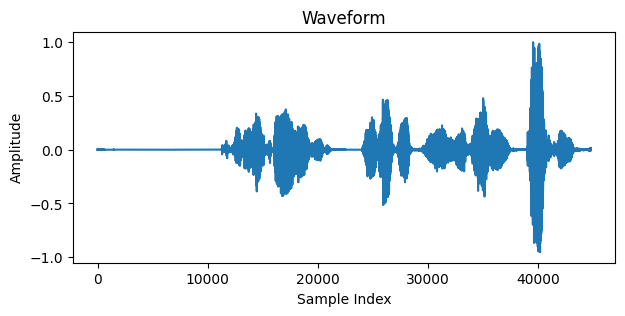

In [ ]:
tp = '/content/drive/MyDrive/dataset/single-channel/denoised_test/b80bb95d16.wav'
tp = '/content/drive/MyDrive/dataset/single-channel/denoised_test/35e670b698.wav'

sample_audio(tp)

In [ ]:
print('ok ..')

ok ..


In [ ]:
submit_df['enroll ID'].value_counts()

spk_71    10332
spk_73    10332
spk_74    10332
spk_75    10332
spk_76    10332
          ...  
spk_10       89
spk_52       85
spk_61       79
spk_17       51
spk_48       36
Name: enroll ID, Length: 75, dtype: int64

In [ ]:
filt = submit_df[submit_df['enroll ID']=='spk_48']
# filt

In [ ]:
for index, r in filt.iterrows():
  print(r)

enroll ID        spk_48
test ID      ff2932141c
score          0.441339
Name: 98503, dtype: object
enroll ID        spk_48
test ID      9bfd1b1936
score          0.249462
Name: 98504, dtype: object
enroll ID        spk_48
test ID      d2d853d909
score          0.008823
Name: 98505, dtype: object
enroll ID        spk_48
test ID      ba1b5fdb53
score          0.082306
Name: 98506, dtype: object
enroll ID        spk_48
test ID      7aa5f2ea60
score          0.236348
Name: 98507, dtype: object
enroll ID        spk_48
test ID      439385df14
score          0.202142
Name: 98508, dtype: object
enroll ID        spk_48
test ID      0fecbc8a57
score          0.779752
Name: 98509, dtype: object
enroll ID        spk_48
test ID      72a61d8890
score          0.158023
Name: 98510, dtype: object
enroll ID        spk_48
test ID      d653363633
score          0.039746
Name: 98511, dtype: object
enroll ID        spk_48
test ID      f04f57b69a
score          1.133466
Name: 98512, dtype: object
enroll ID 

In [ ]:
filt.shape

(36, 3)

#HERE IS THE END >